# FX TaRF Example

This example demonstrates how the scripted trade module can be used to model exotic trades. The script that defines the payoff is embedded in the trade in this example, see Input/tarf_exposure.xml, node `ScriptedTradeData/Script`:

The first two lines contain declarations of variables that are used in the script. Here NUMBER stands for either integers or floating point numbers:

```
NUMBER PnL, AccProfit, Payoff, isTriggered;
NUMBER Fixing, Triggered, d, r;
```

We loop over the fixing dates, which are given as an array in the data section of the trade xml

```
FOR d IN (1, SIZE(FixingDates), 1) DO
```

and retrieve the value of the underlying index on the current fixing date. The underlying can be an equity, fx, commodity, interest rate or inflation index. Notice that the indexing of arrays starts at 1.

```  
Fixing = Underlying(FixingDates[d]);
```

In the next step we calculate the potential payoff generated on the current fixing date. We allow for several ranges with possibly different strikes and leverages to cover all types of TaRFs:

```
  PnL = 0;
  FOR r IN (1, SIZE(RangeLowerBounds), 1) DO
    IF Fixing > RangeLowerBounds[r] AND Fixing <= RangeUpperBounds[r] THEN
      PnL = PnL + RangeLeverages[r] * FixingAmount * (Fixing - RangeStrikes[r]);
    END;
  END;`
```  
 


The payoff on each fixing date can be visualized as follows:

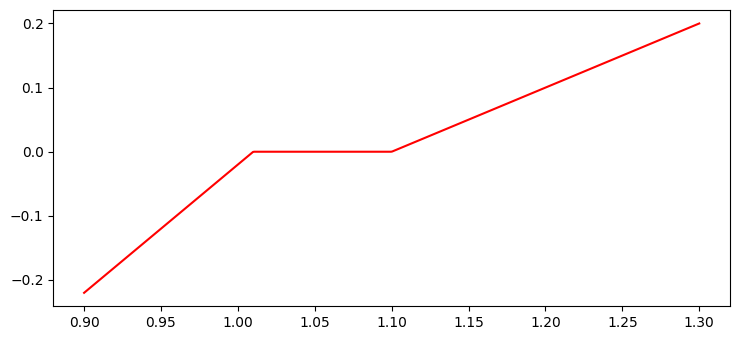

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

def payoff(x):
    if x < 1.01:
        return 2 * (x - 1.01)
    elif x > 1.1:
        return 1 * (x - 1.1)
    else:
        return 0
  
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
x = np.linspace(0.90, 1.3, 500)
plt.plot(x, np.vectorize(payoff)(x), color='red')
plt.show()

If the tarf was not triggered on a previous fixing date we calculate the actual profit generated by the potential payoff
 
```
  IF isTriggered != 1 THEN
    AccProfit = AccProfit + max(PnL, 0.0);
```

and check whether the accumulated profit triggers the knock out amount

```
    IF AccProfit >= KnockOutProfitAmount THEN
      isTriggered = 1;
      Payoff = Payoff + LOGPAY(TargetAmount - (AccProfit - PnL), FixingDates[d], SettlementDates[d], PayCcy, 0, Cashflow);
```

in which case we set the `isTriggered` flag to `1` (meaning true) and set the actual payoff on the fixing date to an amount exactly matching a specified target amount (we have hardcoded a TaRF with "exact target matching" here). In case the knock out amount was not yet triggered we set the actual payoff to the previously computed potential payoff:

```
    ELSE
      Payoff = Payoff + LOGPAY(PnL, FixingDates[d], SettlementDates[d], PayCcy, 0, Cashflow);
    END;
  END;
END;
```

The `PAY()` and `LOGPAY()` functions take an amount, an observation date, a settlement date and a pay currency and convert this into a deflated value in the base currency of the model, i.e. the function yield

\begin{equation}
  \frac{X P_{ccy}(d,p) FX_{\text{ccy},\text{base}}(d)}{N(d)}
\end{equation}

The `LOGPAY()` function will additionally generate an entry in the cashflow report:

\begin{equation}
  \frac{ N(0) E\left(\frac{X P_{ccy}(d,p) FX_{\text{ccy},\text{base}}(d)}{N(d)}\right) }{ FX_{\text{ccy},\text{base}}(0) P_{ccy}(0,p) }
\end{equation}

It takes two additional arguments that determine the leg number of cashflow type displayed in the report.

The NPV is set in the last line of the script

```
value = LongShort * Payoff;
```

The variable name corresponds to the definition of the NPV variable after the script itself:

```
   <NPV>value</NPV>
```

Furthermore we can generate additional results that will be reported in the additional results report:

```
   <Results>
     <Result>isTriggered</Result>
   </Results>
```

The trade is parametrized under the `Data`node and contains the values to parametrized the script. For example


```
        <Event>
          <Name>FixingDates</Name>
          <ScheduleData>
            <Dates>
              <Dates>
                <Date>2023-02-20</Date>
                <Date>2023-03-20</Date>
                <Date>2023-04-20</Date>
                <Date>2023-05-20</Date>
                <Date>2023-06-20</Date>
                <Date>2023-07-20</Date>
                <Date>2023-08-20</Date>
                <Date>2023-09-20</Date>
                <Date>2023-10-20</Date>
                <Date>2023-11-20</Date>
                <Date>2023-12-20</Date>
                <Date>2024-01-20</Date>
                <Date>2024-02-20</Date>
              </Dates>
            </Dates>
          </ScheduleData>
        </Event>
```

represents an array of dates that is accessible under FixingDates in the script.

Let's run the example trade:

In [2]:
from VRE import *
import sys, time, math
sys.path.append('..')
import utilities

In [3]:
params = Parameters()
params.fromFile("Input/vre.xml")
vre = VREApp(params, False)

In [4]:
vre.run()
errors = vre.getErrors()
print ("Completed with", len(errors), "errors/warnings")
if len(errors) > 0:
    for e in errors:
       print(e)
print ("Run time: %.4f sec" % vre.getRunTime())        

Completed with 0 errors/warnings
Run time: 1.2300 sec


The NPV is retrieved from the `value`variable in the script:

In [5]:
utilities.writeReport(vre.getReport("npv"), [0, 1, 2, 4, 5])


TradeId            TradeType          Maturity           NPV                NpvCurrency        
FX_TaRF            ScriptedTrade      2024-02-22         557.6901           USD                


The expected cashflows are given as:

In [6]:
utilities.writeReport(vre.getReport("cashflow"), [2, 4, 5, 6, 7, 16, 17])


CashflowNo         PayDate            FlowType           Amount             Currency           DiscountFactor     PresentValue       
1                  2023-02-22         Cashflow           3629.3196          USD                0.9972             3619.2275          
2                  2023-03-22         Cashflow           8000.6194          USD                0.9936             7949.7414          
3                  2023-04-24         Cashflow           9291.7302          USD                0.9893             9192.6630          
4                  2023-05-23         Cashflow           6963.5646          USD                0.9855             6862.4537          
5                  2023-06-22         Cashflow           4319.7113          USD                0.9815             4239.6143          
6                  2023-07-24         Cashflow           1842.2242          USD                0.9772             1800.2148          
7                  2023-08-22         Cashflow           -332

Let's check if we can reconstruct the NPV from the Cashflows:

In [7]:
cashflows = vre.getReport("cashflow").dataAsReal(17)
cashflowdates = vre.getReport("cashflow").dataAsDate(4)
sum(cashflows)

557.6901167575968

The above run included an exposure calculation using AMC. The script has to be extended a little bit to support this.
Although we could use the extended script also for the NPV calculation, it is usually cleaner to set up separate scripts
for each purpose. Currently there are two specific purposes "FD" and "AMC" that are used in their specific contexts,
i.e. if a backward FD model is configured resp. if an AMC run is done.

Let's look at the extensions of the script to support AMC. We need to record the accumulated profit in AccProfit per fixing date now, therefore we declare this variable as an array now:

```
NUMBER PnL, AccProfit[SIZE(FixingDates)], Payoff, isTriggered;
```

We also need several additional variables


```
NUMBER a, s, NthPayoff[SIZE(FixingDates)], BwdPayoff, _AMC_NPV[SIZE(_AMC_SimDates)];
```

Here `_AMC_SimDates` and `_AMC_NPV` are special variable names. `_AMC_SimDates` is provided by the AMC module and contains the simulation dates of the exposure run. `_AMC_NPV` has to be provided by the script and should contain conditional NPVs for each simulation date. The script continues in a similar way as before. We record the nth payoff in addition since we need this to compute backward NPVs further down below: 

```
IF isTriggered != 1 THEN
  AccProfit[d] = AccProfit[d] + max(PnL, 0.0);
  IF AccProfit[d] >= KnockOutProfitAmount THEN
    isTriggered = 1;
    Payoff = Payoff + LOGPAY(TargetAmount - (AccProfit[d] - PnL), FixingDates[d], SettlementDates[d], PayCcy, 0, Cashflow);
    NthPayoff[d] = LOGPAY(TargetAmount - (AccProfit[d] - PnL), FixingDates[d], SettlementDates[d], PayCcy, 0, Cashflow);
  ELSE
    Payoff = Payoff + LOGPAY(PnL, FixingDates[d], SettlementDates[d], PayCcy, 0, Cashflow);
    NthPayoff[d] = LOGPAY(PnL, FixingDates[d], SettlementDates[d], PayCcy, 0, Cashflow);
  END;
END;
IF d < SIZE(FixingDates) THEN
  AccProfit[d + 1] = AccProfit[d];
END;
```

The following, new portion of the script populates the conditional npv array `_AMC_NPV`:

```
FOR a IN (SIZE(FixingAndSimDates), 1, -1) DO
  s = DATEINDEX(FixingAndSimDates[a], _AMC_SimDates, EQ);
  d = DATEINDEX(FixingAndSimDates[a], FixingDates, GT);
  IF s > 0 THEN
    IF d > 1 THEN
      _AMC_NPV[s] = LongShort * NPVMEM( BwdPayoff, _AMC_SimDates[s], a, 1 == 1, AccProfit[d-1]);
    ELSE
      _AMC_NPV[s] = LongShort * NPVMEM( BwdPayoff, _AMC_SimDates[s], a);
    END;
  END;
  d = DATEINDEX(FixingAndSimDates[a], FixingDates, EQ);
  IF d > 0 THEN
    BwdPayoff = BwdPayoff + NthPayoff[d];
  END;
END;
```

There are several new elements here. The variable FixingAndSimDates contains the set of Fixing and AMC simulation dates and is constructed in the script definition via


```
        <NewSchedules>
          <NewSchedule>
            <Name>FixingAndSimDates</Name>
            <Operation>Join</Operation>
            <Schedules>
              <Schedule>_AMC_SimDates</Schedule>
              <Schedule>FixingDates</Schedule>
            </Schedules>
          </NewSchedule>
        </NewSchedules>
```

The `DATEINDEX()` function is used to identify simulation dates and the last fixing date before the current date. The idea is then to loop backwards over the joined set of fixing and simulation dates. Then:

- if we are on a simulation date (`s>0`) and there is a previous fixing date, we calculate the conditional NPV `_AMC_NPV[s]` for the simulation date as the conditional NPV of the future payoff stored in `BwdPayoff` conditional on the information at the simulation date `_AMC_SimDates[s]`. Here, "information" is represented by the model state enriched by the variable `AccProfit[d-1]`, since besides the model state the accumulated profit up to the simulation date has an impact on the expected future NPV.
- if we are on a simulation date and there is no previous fixing date we do the same as described above, but we don't include the accumulated profit in the conditional NPV calculation
- if we are on a fixing date we update `BwdPayoff` accordingly

The expression `NPV(X, d, [C], [R1], [R2])` calculates a conditional NPV of an amount $X$ conditional on a date $d$, i.e.

\begin{equation}\label{condexp}
  E( X\: | \mathcal{F}_d \cap \mathcal{F}_C )
\end{equation}

where $\mathcal{F}_d$ is the sigma algebra representing the information generated by the model up to $d$ and
$\mathcal{F}_C$ represents the additional condition $C$ (if given). In an MC model is computed using a
regression against the model state at $d$. $C$ can be used to filter the training paths, e.g. on ITM paths only. $d$
must not lie before the evaluation date, but for convenience the scipt engines will treat $d$ as if it were equal to the
evaluation date in this case for the purpose of the NPV function evaluation.

The variant `NPVMEM(X, d, s, [C], [R1], [R2])` works exactly like `NPV(X, d, [C], [R1], [R2])` except that it
takes an additional parameter `s` that must be an integer. If `NPVMEM()` is called more than once for the same
parameter `s` a regression model representing the conditional npv will only be trained once and after that the
trained model will be reused. The usual use case is for scripts used in combination with the AMC module where a
regression model will be trained on a relative large number of paths (specified in the pricing engine configuration) and
then reused in the global exposure simulation on a relatively small number of paths (specified in the xva simulation
setup).

Finally, the node

```
        <ConditionalExpectation>
          <ModelStates>
            <ModelState>Asset</ModelState>
          </ModelStates>
        </ConditionalExpectation>
```

specifies that only "Asset" states (EQ, FX, COMM, but not IR, INF) are included in the conditional NPV calculation. We do this since the IR state has relatively little explanatory power in this context and reducing the number of state variables increases performance and robustness of the regression analysis.

Let's look at the generated EPE and ENE:

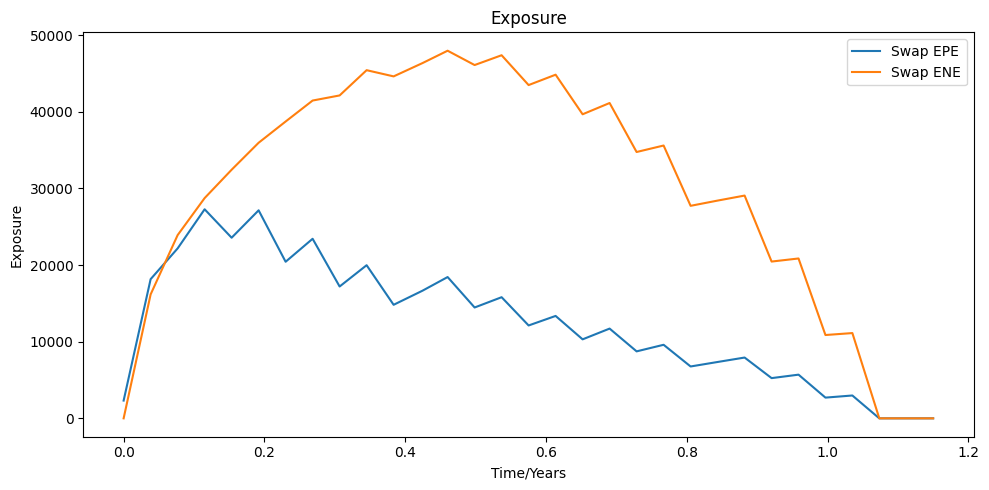

In [8]:
report = vre.getReport("exposure_trade_FX_TaRF")

time = report.dataAsReal(2)
epe = report.dataAsReal(3);
ene = report.dataAsReal(4);
    
fig = plt.figure(figsize=(10, 5))
gs = plt.GridSpec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0, 0])

ax.plot(time, epe, label='Swap EPE')
ax.plot(time, ene, label='Swap ENE')
ax.set(xlabel='Time/Years')
ax.set(ylabel='Exposure')
ax.set_title('Exposure')
ax.legend()

plt.show()

Comparison of EPE - ENE vs. the sum of future cashflow pvs. We don't expect an exact match here, because the T0 pricing / cashflow reporting uses a different model calibration than the exposure simulation. After aligning the exposure simulation setup with the pricing setup in this regard, the match improves.

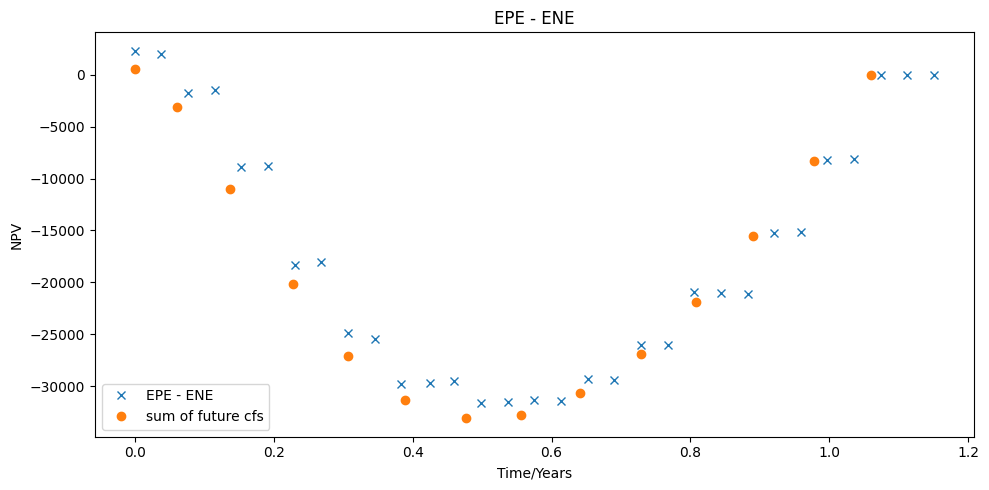

In [9]:
def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

x_epeene = time
y_epeene = []
for i in range(0,len(epe)):
    y_epeene.append(epe[i] - ene[i])
    
x_futurecfs = [0]
y_futurecfs = [sum(cashflows)]
for i in range(0,len(cashflows)):
    x_futurecfs.append((ql_to_datetime(cashflowdates[i]) - datetime.datetime(2023,1,31)).days / 365)
    y_futurecfs.append(sum(cashflows[i+1:]))
    
fig = plt.figure(figsize=(10, 5))
gs = plt.GridSpec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0, 0])

ax.plot(x_epeene, y_epeene, label='EPE - ENE', marker='x', linestyle='none')
ax.plot(x_futurecfs, y_futurecfs, label='sum of future cfs', marker='o', linestyle='none')
ax.set(xlabel='Time/Years')
ax.set(ylabel='NPV')
ax.set_title('EPE - ENE')
ax.legend()

plt.show()